In [2]:
# https://www.kaggle.com/datasets/whenamancodes/fraud-detection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [83]:
#loading and inspecting the dataset 
df = pd.read_csv("creditcard.csv")

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [97]:
df.head(2)
# no encoding or standartization needed, values have been pre-processed already

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [91]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [89]:
# the dataset is highly imbalaned, later on I'll try to balance the weights 
df["Class"].value_counts(normalize = True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

In [147]:
# removing the features with weights < 0.009 (see step with feature importances further)
x = df.drop(["Class"], axis = 1)
x = df[["V14", "V10", "V2", "V8"]]
y = df["Class"]
x.head(2)

,V14,V10,V2,V8
0,-0.311169,0.090794,-0.072781,0.098698
1,-0.143772,-0.166974,0.266151,0.085102


In [153]:
# splitting the dataset and defining the scale_pos_weight to balance class weights
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

fraud_cases = np.sum(y_train == 1)
normal_cases = np.sum(y_train == 0)

scale_pos_weight = normal_cases / fraud_cases
scale_pos_weight

573.2069892473119

In [159]:
# fitting and predicting XGBoost model 
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

model_1 = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=573)
model_1.fit(x_train, y_train)
predictions_xgb = model_1.predict(x_test)


In [161]:
accuracy= accuracy_score(y_test,predictions)
print('Accuracy of the eXtreme Gradient Boosting model is:', accuracy*100)

Accuracy of the eXtreme Gradient Boosting model is: 99.93679952810315


In [135]:
feature_importance = pd.DataFrame({'Feature': x_train.columns, 'Importance': model_1.feature_importances_})
print(feature_importance.sort_values(by='Importance', ascending=False))


   Feature  Importance
14     V14    0.636757
10     V10    0.287925
2       V2    0.023042
8       V8    0.009865
17     V17    0.003233
7       V7    0.002700
12     V12    0.002463
4       V4    0.002446
16     V16    0.002429
28     V28    0.001991
11     V11    0.001954
6       V6    0.001880
27     V27    0.001725
1       V1    0.001677
29  Amount    0.001566
19     V19    0.001565
5       V5    0.001551
21     V21    0.001542
23     V23    0.001517
25     V25    0.001437
9       V9    0.001368
3       V3    0.001366
13     V13    0.001255
20     V20    0.001241
18     V18    0.001238
26     V26    0.001232
0     Time    0.000909
24     V24    0.000746
22     V22    0.000696
15     V15    0.000686


In [165]:
# the results seem to be very good for the XGBoost model, let's compare it with the deep learning model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
input = InputLayer(shape = (x_train.shape[1],))
model.add(input)

model_2 = Sequential([
    InputLayer(shape = (x_train.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid') 
])
opt = Adam(learning_rate = 0.01)
model_2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model_2.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))
predictions_dl = model_2.predict(x_test)

test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')


Epoch 1/5
6676/6676 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.9979 - loss: 0.0150 - val_accuracy: 0.9994 - val_loss: 0.0047
Epoch 2/5
6676/6676 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9990 - loss: 0.0057 - val_accuracy: 0.9958 - val_loss: 0.0149
Epoch 3/5
6676/6676 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 4/5
6676/6676 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9989 - loss: 0.0063 - val_accuracy: 0.9989 - val_loss: 0.0049
Epoch 5/5
6676/6676 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9992 - loss: 0.0047 - val_accuracy: 0.9994 - val_loss: 0.0036
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2226/2226 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9994 - loss: 0.0036
Test Accuracy: 1.00


In [167]:
#let's compare metrics for both models 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
predictions_keras = model_2.predict(x_test)
predictions_keras = (predictions_keras > 0.5).astype(int)

predictions_xgb = model_1.predict(x_test)
predictions_xgb = (predictions_xgb > 0.5).astype(int)
print(f"XGBoost Accuracy: {accuracy_score(y_test, predictions_keras):.2f}")
print(f"Keras Accuracy: {accuracy_score(y_test, predictions_xgb):.2f}")

print(f"XGBoost Precision: {precision_score(y_test, predictions_keras):.2f}")
print(f"Keras Precision: {precision_score(y_test, predictions_xgb):.2f}")

print(f"XGBoost Recall: {recall_score(y_test, predictions_keras):.2f}")
print(f"Keras Recall: {recall_score(y_test, predictions_xgb):.2f}")

print(f"XGBoost F1-score: {f1_score(y_test, predictions_keras):.2f}")
print(f"Keras F1-score: {f1_score(y_test, predictions_xgb):.2f}")

print(f"XGBoost AUC-ROC: {roc_auc_score(y_test, predictions_keras):.2f}")
print(f"Keras AUC-ROC: {roc_auc_score(y_test, predictions_xgb):.2f}")


2226/2226 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
XGBoost Accuracy: 1.00
Keras Accuracy: 1.00
XGBoost Precision: 0.82
Keras Precision: 0.75
XGBoost Recall: 0.80
Keras Recall: 0.78
XGBoost F1-score: 0.81
Keras F1-score: 0.76
XGBoost AUC-ROC: 0.90
Keras AUC-ROC: 0.89


2226/2226 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


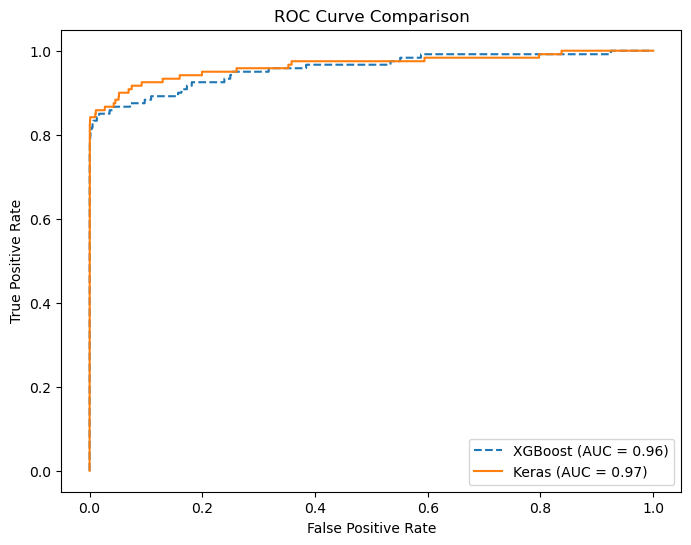

In [171]:
# plotting the ROC/AUC 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, model_1.predict_proba(x_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_keras, tpr_keras, _ = roc_curve(y_test, model_2.predict(x_test).ravel())
roc_auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})", linestyle='--')
plt.plot(fpr_keras, tpr_keras, label=f"Keras (AUC = {roc_auc_keras:.2f})", linestyle='-')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


In [169]:
# Both models did very nicely with the ROC/AUC
# XGBoost model is showing higher F1-score and Recall, indicating better handling of class imbalance!